One of the major discussions in the newsies fandom is this idea of a multi-generational fandom, and the impacts of having source material produced 20 years appart, and viewed by different generational audiances.

# Getting ready to analyze the data

We'll start by setting up our analysis libraries and formatting the data.

In [1]:
import itertools as it
import os
import re

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from matplotlib import rcParams
from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd 
import seaborn as sn
import scipy
import statsmodels.formula.api as smf

from scripts.tabulate_dict import describe_column

# Makes the data use Arial or Helvetica as its default font
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial, Helvetica, Lucida Grande, sans-serif'

%matplotlib inline

We'll use a color palette called "Newsies" developed by [color-pals on tumblr](). You could theoretically skip this step if you're happy with the matplotlib defaults or if you wanted to set another color palette.

Newsies is kind of a blue/brown palette, and shoudl be semi colorblind friendly.

In [2]:
# Sets up a color palette based on the newsies
# colors = ['#473934', '#696562', '#B8AEB3', '#8C9BBF', '#4E5E82', '#132143']
colors = ['#473934', '#C25244', '#EFDFAF', '#ABCDE3', '#6081A7', '#120E0A']
sn.set_palette(colors)
sn.color_palette(colors)

[(0.2784313725490196, 0.2235294117647059, 0.20392156862745098),
 (0.7607843137254902, 0.3215686274509804, 0.26666666666666666),
 (0.9372549019607843, 0.8745098039215686, 0.6862745098039216),
 (0.6705882352941176, 0.803921568627451, 0.8901960784313725),
 (0.3764705882352941, 0.5058823529411764, 0.6549019607843137),
 (0.07058823529411765, 0.054901960784313725, 0.0392156862745098)]

And now, we need to read in the data, data dictionary, and location information.

In [3]:
data = pd.read_csv('../data/survey_data.tsv', sep='\t', dtype=str)
data_dict = pd.read_csv('../data/data_dictionary.tsv', sep='\t', dtype=str,
                        index_col='short_name')

In [4]:
print(describe_column('consent', data_dict, data))

Item 1: consent (multiple choice)

I certify that the nature and purpose, the potential benefits and possible
risks associated with participation in this research study have been explained
to the above individual and that any questions about this information have
been answered. This electronic consent stands in place of my signature.


     ----------------------------------------------------------------------
       Response                                                 Count
     ----------------------------------------------------------------------
       I am over the age of 18 and I consent to participate      160 
     ----------------------------------------------------------------------

Data cleaning notes
-------------------
   * This question was required for all participants


In [5]:
print('There are {:d} people in the final survey dataset.'.format(len(data)))

There are 160 people in the final survey dataset.


We're going to look at generation effects, and I'm specificially interested in age, fandom activity, first show, participation, and activities, as well as gender.

In [6]:
cols = np.hstack([
    ['consent', 'demography_age', 'demography_gender', 'demography_trans'],
    ['first_media', 'first_period', 'media_preference', 'period_active_tidy'],
    [c for c in data_dict.index if 'all_media_seen' in c],
    [c for c in data_dict.index if 'movie1992_seen' in c],
    [c for c in data_dict.index if 'newsies_live_seen' in c],
    [c for c in data_dict.index if 'performance_seen' in c],
    [c for c in data_dict.index if 'fannish_platforms' in c], 
    [c for c in data_dict.index if 'fanish_content_consumed' in c], 
    [c for c in data_dict.index if 'fannish_content_produced' in c],
])      
data = data[cols].copy()
data.dropna(inplace=True)

data_dict = data_dict.loc[data.columns]

data.rename(columns={c: c.replace('demography_', '') for c in data.columns}, 
            inplace=True)
data_dict.rename(index={c: c.replace('demography_', '') for c in data_dict.index},
                 inplace=True)

In [7]:
print('There are {0:d} respondents in this focused analysis'.format(len(data)))

There are 131 respondents in this focused analysis


Let's just tabulate the age column

In [8]:
print(describe_column('age', data_dict, data, show_notes=False))

Item 35: age (multiple choice)

1. How old are you?


     ----------------------------------------------------------------------
       Response                                                 Count
     ----------------------------------------------------------------------
       18 - 21                                                    65 
       22 - 25                                                    26 
       26 - 30                                                    17 
       31 - 35                                                     8 
       36 - 40                                                    12 
       41 - 45                                                     2 
       46 - 60                                                     1 
     ----------------------------------------------------------------------



I'm going to group in three ways: I want to have a 40+ group, a 36+ group, and then a "generation" group with a 10 year block.

In [9]:
data.replace({"age": {'46 - 60': '41 - 60', '41 - 45': '41 - 60'}}, inplace=True)
data['age2'] = data['age'].replace({'41 - 60': '36 - 60', '36 - 40': '36 - 60'})
data['age3'] = data['age2'].replace({'26 - 30': '26 - 35',
                                     '31 - 35': '26 - 35',
                                     })

Let's also look at gender.

In [10]:
print(describe_column('gender', data_dict, data, show_notes=False))

Item 36: gender (multiple choice)

2. What is your gender identity?


     ----------------------------------------------------------------------
       Response                                                 Count
     ----------------------------------------------------------------------
       Female                                                     89 
       Male                                                       11 
       Nonbinary                                                  22 
       Genderqueer                                                 5 
     ----------------------------------------------------------------------



In [11]:
print(describe_column('trans', data_dict, data, show_notes=False))

Item 37: trans (multiple choice)

3. Do you identify as trans?


     ----------------------------------------------------------------------
       Response                                                 Count
     ----------------------------------------------------------------------
       No                                                        106 
       Yes                                                        25 
     ----------------------------------------------------------------------



So, I want to create a joint column looking at this dataset.

In [12]:
data['gender2'] = \
    data[['gender', 'trans']].replace({"Yes": 'trans', 'No': 'cis'}).apply(
        lambda x: x['gender'].lower() 
            if x['gender'] in {'Nonbinary', 'Genderqueer', 'Questioning'} 
            else '{trans} {gender}'.format(**x.to_dict()).lower(),
        axis=1
    )
data['gender2'].value_counts()

cis female     89
nonbinary      22
trans male      8
genderqueer     5
questioning     4
cis male        3
Name: gender2, dtype: int64

# Timing of Newsies fandom and the survey participants

I want to start by building a timeline of major events in the newsies fandom. I think the following events are major dates in terms of the 1992 movie:

* April 10, 1992 - Movie Premier
* May 11, 2001 - Movie released on DVD
* June 19, 2012 - 20th anniversary release of the movie
* April 1, 2015 - Live movie screening at El Capitan theater
* November 1, 2019 - 1992 movie avaliable on Disney +

(For the sake of the figure, we're going to skip the 20th anniversery DVD, but I can't and ugh)

The movie is still avaliable on Disney+ as of April 10, 2022 when I'm writing thsi notebook, and our survey ended on December 31, 2021, so I'm going to treat it as ongoing and display a duration.



In [13]:
movie_events = pd.DataFrame.from_dict(
    orient='index',
    data={
        '04-10-1992': {'name': 'Movie', 'y': 1},
        '05-11-2001': {'name': 'DVD release', 'y': 1},
        '04-01-2015': {'name': 'El Capitan', 'y': 1.5}
    }
)

movie_durations = pd.DataFrame(
    data=[['11-01-2019', '02-01-2022', 0]],
    columns=['begin', 'end', 'y'],
    index=['Disney+'],
)

I see these as major dates associated with the play:
* September 25, 2011 - Newsies premiers at Papermill
* May 16, 2012 - Newsies previews on Broadway
* August 24, 2014 - Newsies closes on Broadway
* October 10, 2014 - Newsies national tour starts
* October 2, 2016 - Newsies national tour ends
* February 16, 17 2017 - Newsies Live shown in theaters as part of Fathom events
* September 5, 2017 - Newsies Live is relased on Netflxi in the US
* March 1, 2019 - Newsies Live is removed from Netflix
* November 1, 2019 - Newsies Live is avaliable to stream through Disney +

Most of these can be represented as durations, rather than as single events.

In [33]:
play_events = pd.DataFrame.from_dict(
    orient='index',
    data={
        '09-25-2011': {'name': 'Papermill', 'y': 1.5},
        '02-16-2017': {'name': 'Live!', 'y': 0.75},
    }
)
play_durations = pd.DataFrame(
    data=[['05-16-2012', '08-24-2014', 0],
          ['10-10-2014', '10-02-2016', 0],
          ['09-05-2017', '03-01-2019', 0],
          ['11-01-2019', '02-01-2022', 0]],
    index=['Broadway', 'Tour', 'Netflix', 'Disney+'],
    columns=['begin', 'end', 'y']
)

In [34]:
# Combine the events and make the dates into computer-readable dates
combo_events = pd.concat(axis=0, objs=[movie_events, play_events])
combo_events.index = pd.to_datetime(combo_events.index)

# Combine the durations, drop the duplicates, and make the dates into 
# computer-readable dates
combo_durations = pd.concat(axis=0, objs=[movie_durations, play_durations])
combo_durations.drop_duplicates(inplace=True)
combo_durations['begin'] = pd.to_datetime(combo_durations['begin'])
combo_durations['end'] = pd.to_datetime(combo_durations['end'])
combo_durations['y'] = combo_durations['y'].astype(int)

special_z = {'El Capitan': 0}

I'm also going to build a list of important events, although I may never use them. Because for some reason, matplotlib currently hates me.

There will include presidents, recessions, and 9/11, which I think was a defining event. I coudl have also included Columbine, the fall of the Berlin wall (although that falls outside the interval we're looking at), and a few others.

In [35]:
presidents = pd.DataFrame(
    data=[['01-20-1989', '01-19-1993', 'r'],
          ['01-20-1993', '01-19-2001', 'd'],
          ['01-20-2001', '01-19-2009', 'r'],
          ['01-20-2009', '01-19-2017', 'd'],
          ['01-20-2017', '01-19-2021', 'r'],
          ['01-20-2021', '01-19-2025', 'd'],
          ],
    columns=['start', 'end', 'party'],
    index=['George HW Bush', 'Bill Clinton', 'George W Bush', 
           'Barack Obama', 'Donald Trump', 'Joe Biden']
)
presidents['start'] = pd.to_datetime(presidents['start'])
presidents['end'] = pd.to_datetime(presidents['end'])

party_colors = {'r': '#e9141d',
                'd': '#0015BC'
                }

recessions = pd.DataFrame(
    data=[['03-01-2001', '12-01-2001'],
          ['12-01-2007', '06-30-2009'],
          ['03-15-2020', '06-30-2022'],
          ],
    columns=['start', 'end'],
    index=['Dot Com', 'Great Recession', 'COVID 19'],
)
recessions['start'] = pd.to_datetime(recessions['start'])
recessions['end'] = pd.to_datetime(recessions['end'])

major_events = pd.Series(
    {'09-11-2001': '9/11'}
)
major_events.index = pd.to_datetime(major_events.index)

Let's start by plotting a single timeline. Note that these figures are specifically diesnged for powerpoint display initially, so we'll adjsut slightly later.

In [36]:
event_fmt = dict(linestyle='-', linewidth=1, color='#252525')

In [286]:
# For the sake of all fugure happiness, I'm going to build some functions because
# otherwise, I s2g my life will suck

def _create_tl_figure(num_rows, dpi=150):
    """
    Makes the timeline figure
    """
    fig = plt.figure(dpi=dpi, 
                    constrained_layout=False, 
                    figsize=(6, 3), 
                    facecolor='None')
    gs = tl_fig.add_gridspec(num_rows, 8)
    
    return fig, gs

def _build_ref_ax(ax, events=combo_events, durations=combo_durations):
    """
    Builds the timeline reference axis
    """
    # Formats the y axis
    ax.set_ylim(0, 3)
    ax.yaxis.set_tick_params(labelbottom=False, bottom=False)
    # Formats the x axis
    ax.set_xlim(pd.to_datetime('01-01-1992'), pd.to_datetime('12-31-2021'))
    ax.xaxis.set_tick_params(top=False, labeltop=False,
                             bottom=True, labelbottom=True,
                             labelsize=7)
    # Despines so the top and sides are hidden
    sn.despine(ax=ax, left=True, right=True, top=True, 
               bottom=False)
    
    # Plots the events
    for date, (event, y) in events.iterrows():
        ax.plot([date] * 2, [-1, y], 
                zorder=special_z.get(event, None), 
                **event_fmt)
        ax.text(date, y, event, 
                ha='center', va='bottom', 
                size=6, 
                color='#252525')
    # Plots the durations
    for event, [stop, start, y] in durations.iterrows():
        ax.fill_between([start, stop], 
                        y1=y, y2=y+1.2, 
                        color='#dbdbdb', 
                        edgecolor='None')
        ax.text((stop - start) / 2 + start, y+1.2/2, event, 
                ha='center', va='center', 
                size=6
                )

def _plot_ref_dur(ax, y0, y1, events=combo_events, durations=combo_durations):
    """
    Plots the newsies events on other axes
    """
    # Adds the events
    for date, (event, y) in events.iterrows():
        ax.plot([date] * 2, [y0, y1], **event_fmt)

    for event, [stop, start, y] in durations.iterrows():
        ax.fill_between([start, stop], 
                        y1=y0, y2=y1, 
                        color='#dbdbdb', 
                        edgecolor='None')
    # Formats the x and y axes
    ax.yaxis.set_tick_params(labelsize=7)
    ax.xaxis.set_tick_params(labelsize=7)
        
def _plot_cohort_strip(ax, start, stop, y0, y1, color, label, 
                       font_color='k', min_date='1992-01-01'):
    """
    Plots fandom activity during a period
    """
    
    min_date = pd.to_datetime(min_date)
    if stop >= min_date:
        first = max(start, min_date)
        ax.fill_between([first, stop], y1=y0, y2=y1, 
                        color=color, 
                        edgecolor='None',
                        alpha=0.75,
                        zorder=1)
        ax.text(first + (stop - first) / 2, np.mean([y0, y1]), label,
                ha='center', va='center', 
                size=8,
                zorder=2,
                color=font_color
               )
        

        
def _plot_activity(ax, events, colors):
    """
    Plots fandom activity over the course of the years
    """
    def _define_steps(events):
        timeline = []
        counts = []
        for (d0, c0), (d1, c1) in zip(*(events.items(), events[1:].items())):
            timeline.extend([d0, d1])
            counts.extend([c0, c0])
        return pd.Series(counts, index=timeline)
    
    steps = _define_steps(events)
    
    ax.fill_between(steps.index, y1=0, y2=steps.values, 
                    color=color, edgecolor='None',
                    alpha=0.5,
                    )
    ax.plot(steps.index, steps.values, color=color)

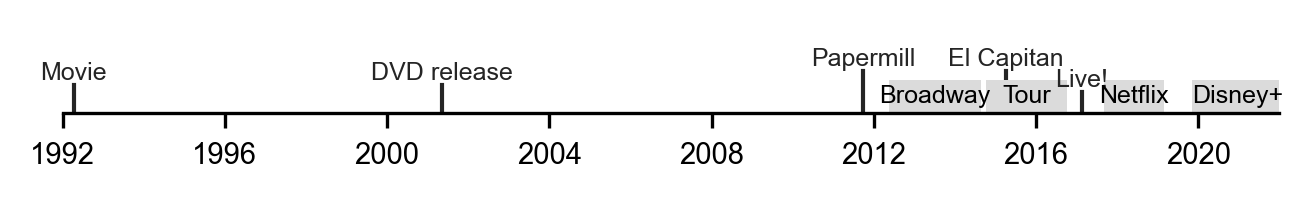

In [287]:
fig1, gs1 = _create_tl_figure(7, dpi=300)
ax1_tl = fig1.add_subplot(gs1[0, 1:], facecolor='None')
_build_ref_ax(ax1_tl)

## All fan activity

I want to look at the period people have been active in fandom, just on the whole.

In [288]:
print(describe_column('period_active', data_dict, data))

Item 17: period_active_tidy (derived)

22. During what years were you active in Newsies fandom? (Please write YYYY to
YYYY; please write YYYY to Present if you are currently active)

Data cleaning notes
-------------------
   * Free text from the `period_active` field was standardized into a machine
     readable-format.
   * Distinct periods of activity were seperated with a semi-colon (;) (i.e the
     entry 1992-1995;2002-2005 indivates the individul was active both between
     1992 and 1995 and between 2002 and 2005, but not between 1995 and 2002.)
   * Duration is described using a consistent format for multi-year periods:
     YYYY-YYYY
   * Single year formats are left as a single number: YYYY
   * Times indicating "present" for fandom participation was simplified to 2021,
     since this was the end of the survery period.
   * Any description indicating uncertainty has been removed (i.e. 2012ish
     becomes 2012)
   * If users specified a period of particular activity, this h

In [289]:
period_active = data.set_index('age3')['period_active_tidy'].dropna().copy()
# period_active.rename({"36 - 40": '36+', '41+': '36+'}, inplace=True)
age_groups = period_active.index.to_frame()['age3'].value_counts()
period_active = period_active.apply(lambda x: pd.Series(x.split('; '))).unstack()
period_active.dropna(inplace=True)
period_active.reset_index(level=0, drop=True, inplace=True)
period_active = period_active.apply(
    lambda x: '01-01-{0} - 12-31-{1}'.format(*x.split('-')) if ('-' in x)
    else '01-01-{0} - 12-31-{0}'.format(x)
)
# I want to add a linkage for present so we'll extend that past the end of the period
period_active.apply(lambda x: x.replace('12-31-2021', '03-31-2022'))
period_active = period_active.apply(lambda x: pd.Series(x.split(" - "), 
                                                        index=['start', 'stop'])
                                    )
period_active['start'] = pd.to_datetime(period_active['start'])
period_active['stop'] = pd.to_datetime(period_active['stop']) + pd.Timedelta('1D')

long_active = period_active.reset_index().melt(
    id_vars='age3',
    var_name='event',
    value_name='date'
)
long_active.replace({'event': {'start': 1, 'stop': -1}}, inplace=True)
long_active.set_index(['age3', 'date'], inplace=True)

by_year_count = long_active.groupby('date', sort=True).sum()['event']
by_year_count = by_year_count.cumsum()
by_year_perc = by_year_count / data['period_active_tidy'].notna().sum()
by_age_year_count = \
    long_active.groupby(['age3', 'date'], sort=True).sum()['event']
by_age_year_count = by_age_year_count.cumsum()

by_age_year_perc = by_age_year_count / \
    by_age_year_count.index.to_frame()['age3'].replace(age_groups.to_dict())



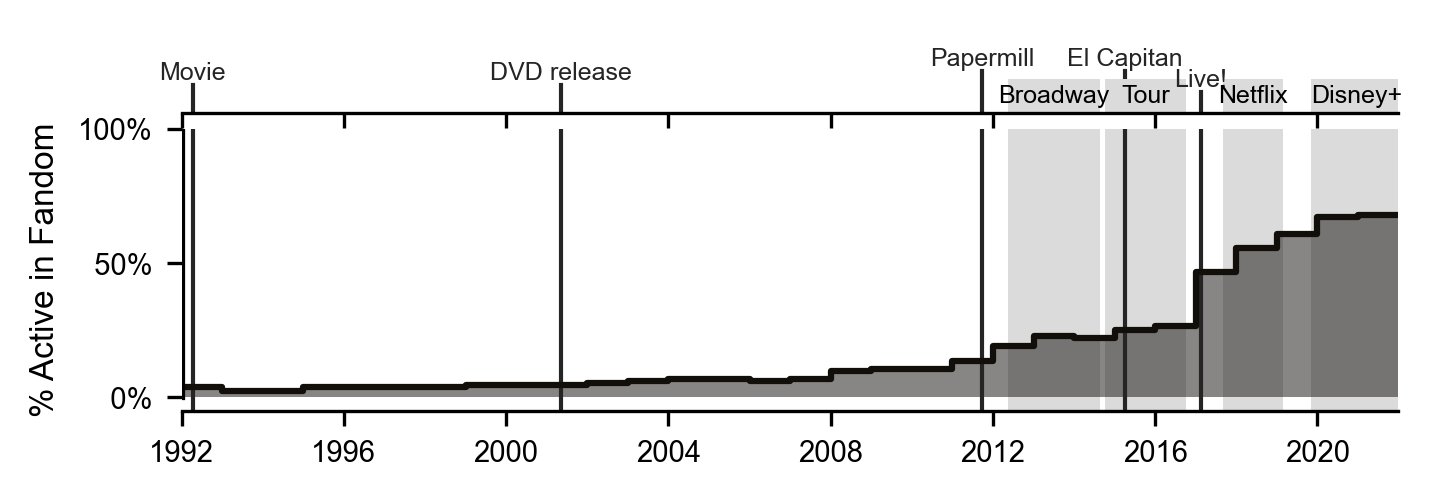

In [290]:
fig2, gs2 = _create_tl_figure(7, dpi=300)
# Creates the newsies timeline 
ax2_tl = fig2.add_subplot(gs2[0, 1:], facecolor='None')
_build_ref_ax(ax2_tl)
ax2_tl.xaxis.set_tick_params(labelbottom=False)

# Plots the fan activity
ax2_fa = fig2.add_subplot(gs2[1:4, 1:], facecolor='None', sharex=ax2_tl)
ax2_fa.set_ylim(-0.05, 1)
_plot_ref_dur(ax2_fa, -0.1, 1.1)
_plot_activity(ax2_fa, by_year_perc, colors[0])
# Plots a y axis for ax2 so we can trim the axes
ax2_fa.plot([ax2_fa.get_xlim()[0]] * 2, [0, 1], 'k-')
sn.despine(ax=ax2_fa, left=True, top=True, right=True)
ax2_fa.set_ylabel('% Active in Fandom', size=8)
ax2_fa.yaxis.set_major_formatter('{x:>4.0%}')

# Displaying generations

And then I want to format the age data so we can look at how that gets broken down. I want to use the broadest age categories, because I think we'll group these later. But, let's look at that.

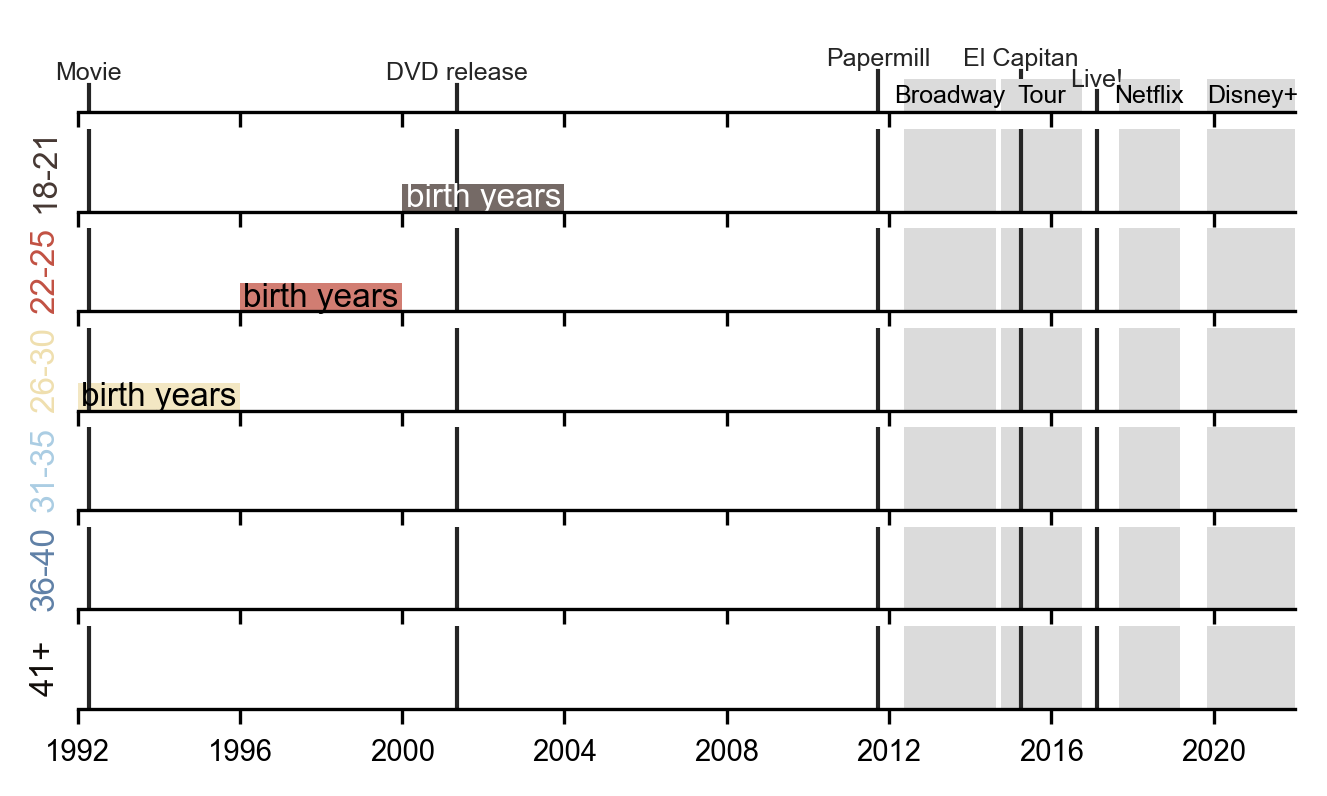

In [291]:
# Figures out the birth cohorts
ages = data['age'].copy()
cohorts_1 =ages.drop_duplicates().sort_values().apply(
    lambda x: pd.Series(x.replace('+', ' - 60').split(' - '), 
                        index=['youngest', 'oldest'])
)
cohorts_1 = cohorts_1.astype(int)
cohorts_1
birth_range = pd.DataFrame(
    data=[
        pd.to_datetime((2021 - cohorts_1['oldest']).apply(
            lambda x: f'01-01-{x}')).dt.round('D'),
        pd.to_datetime((2021 - cohorts_1['youngest']).apply(
            lambda x: f'12-31-{x}')).dt.round('D'),
    ],
    index=['early', 'late']
).T
birth_range.index = cohorts_1.apply(lambda x: '{0:d} - {1:d}'.format(*x.values), axis=1)
birth_range['counts'] = ages.value_counts().sort_index()
birth_range['perc'] = ages.value_counts().sort_index() / len(ages)
birth_range['cum_prec'] = birth_range['perc'].cumsum() - birth_range['perc']
# birth_range

# Plots the reference
fig3, gs3 = _create_tl_figure(7, dpi=300)
ax3_tl = fig3.add_subplot(gs3[0, 1:], facecolor='None')
_build_ref_ax(ax3_tl)
ax3_tl.xaxis.set_tick_params(labelbottom=False)

cohort_axes = []
for i, ((age, [early, late, counts, perc, cperc]), color) in \
        enumerate(zip(*(birth_range.iterrows(), colors))):
    
    # Makes the axis
    ax = fig3.add_subplot(gs3[i+1, 1:], facecolor='None', sharex=ax3_tl)
    ax.set_ylim(0, 3)
    _plot_ref_dur(ax, -0.1, 3.1)
    ax.xaxis.set_tick_params(labelbottom=(i == len(birth_range) - 1))
    ax.yaxis.set_tick_params(left=False, labelleft=False)

    # Plots the birth years
    _plot_cohort_strip(ax, early, late, 0, 1, color=color, label='birth years', 
                       font_color={0: 'white', 5: 'white'}.get(i, 'k'))
    ax.set_ylabel(age.replace(" - 60", '+').replace(" ", ''), color=color, size=8)
    
    sn.despine(ax=ax, left=True, right=True, top=True, bottom=False)

# 15 year olds etc


One of my favorite observations in hte Newsies Gothic is this idea around 15 year olds (maybe because i'm an Newsies Old)

> The fandom is full of fifteen year olds.  A year passes, then another, then another.  You are older now, and tired.  The fifteen-year-olds have not aged. 

So, I want to add a 15 year old period to this.

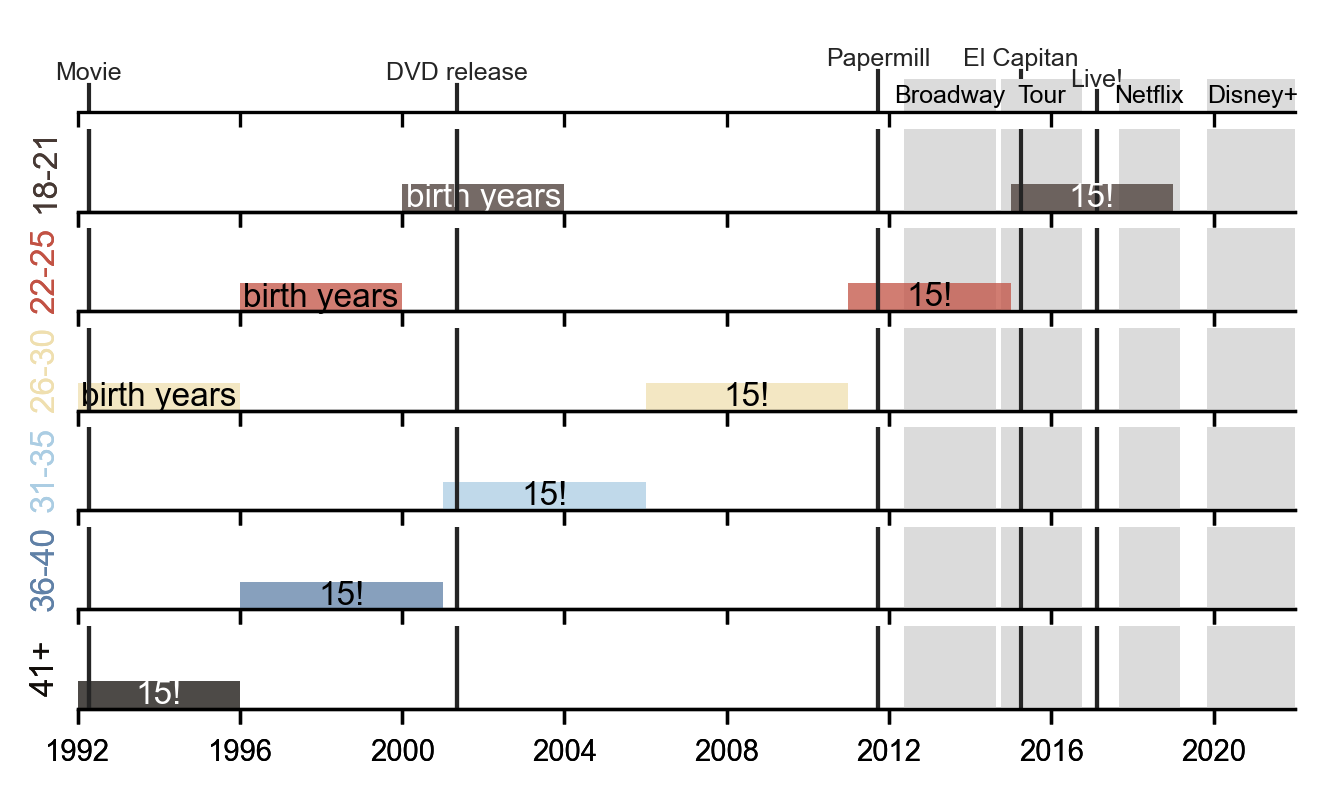

In [292]:
for i, ((age, [early, late, counts, perc, cperc]), color) in \
        enumerate(zip(*(birth_range.iterrows(), colors))):
    
    early = early + pd.Timedelta('365.25D') * 15
    late = late + pd.Timedelta('365.25D') * 15
    
    # Makes the axis
    ax = fig3.add_subplot(gs3[i+1, 1:], facecolor='None', sharex=ax3_tl)
    ax.set_ylim(0, 3)
    _plot_ref_dur(ax, -0.1, 3.1)
    ax.xaxis.set_tick_params(labelbottom=(i == len(birth_range) - 1))
    ax.yaxis.set_tick_params(left=False, labelleft=False)

    # Plots the birth years
    _plot_cohort_strip(ax, early, late, 0, 1, color=color, label='15!', 
                       font_color={0: 'white', 5: 'white'}.get(i, 'k'))
    ax.set_ylabel(age.replace(" - 60", '+').replace(" ", ''), color=color, size=8)
    
    sn.despine(ax=ax, left=True, right=True, top=True, bottom=False)
    
fig3

# Regrouped birth cohorts

Okay, and then I want to re-group the data into 4 cohorts, which meaans the figure might end up changing. Which is just kinda weird.

18 - 21
22 - 25
26 - 35
36 - 60


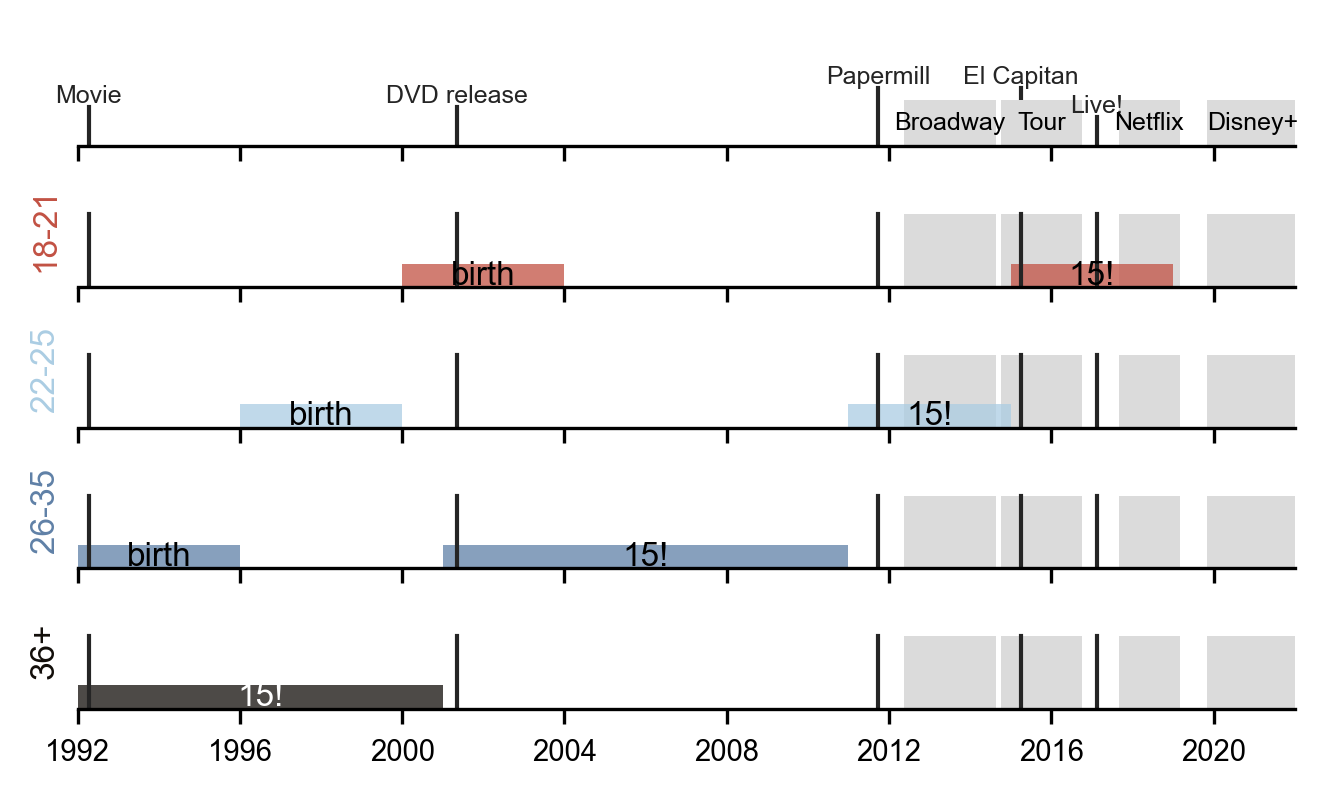

In [293]:
ages = data['age3'].copy()
cohorts_1 =ages.drop_duplicates().sort_values().apply(
    lambda x: pd.Series(x.replace('+', ' - 60').split(' - '), 
                        index=['youngest', 'oldest'])
)
cohorts_1 = cohorts_1.astype(int)
cohorts_1
birth_range = pd.DataFrame(
    data=[
        pd.to_datetime((2021 - cohorts_1['oldest']).apply(
            lambda x: f'01-01-{x}')).dt.round('D'),
        pd.to_datetime((2021 - cohorts_1['youngest']).apply(
            lambda x: f'12-31-{x}')).dt.round('D'),
    ],
    index=['early', 'late']
).T
birth_range.index = cohorts_1.apply(lambda x: '{0:d} - {1:d}'.format(*x.values), axis=1)
birth_range['counts'] = ages.value_counts().sort_index()
birth_range['perc'] = ages.value_counts().sort_index() / len(ages)
birth_range['cum_prec'] = birth_range['perc'].cumsum() - birth_range['perc']

colors2 = [colors[1], colors[3], colors[4], colors[-1]]


# Plots the reference
fig4, gs4 = _create_tl_figure(5, dpi=300)
ax4_tl = fig4.add_subplot(gs4[0, 1:], facecolor='None')
_build_ref_ax(ax4_tl)
ax4_tl.xaxis.set_tick_params(labelbottom=False)

cohort_axes = []
for i, ((age, [early, late, counts, perc, cperc]), color) in \
        enumerate(zip(*(birth_range.iterrows(), colors2))):
    print(age)
    # Makes the axis
    ax = fig4.add_subplot(gs4[i+1, 1:], facecolor='None', sharex=ax4_tl)
    ax.set_ylim(0, 5)
    _plot_ref_dur(ax, -0.1, 3.1)
    ax.xaxis.set_tick_params(labelbottom=(i == len(birth_range) - 1))
    ax.yaxis.set_tick_params(left=False, labelleft=False)

    # Plots the birth years
    _plot_cohort_strip(ax, early, late, 0, 1, 
                       color=color, 
                       label='birth', 
                       font_color={3: 'white'}.get(i, 'k'))
    early_15 = early + pd.Timedelta('365.25D') * 15
    late_15 = late + pd.Timedelta('365.25D') * 15
    _plot_cohort_strip(ax, early_15, late_15, 0, 1,
                       color=color, label='15!', 
                       font_color={3: 'white'}.get(i, 'k')
                       )
    
    
    ax.set_ylabel(age.replace(" - 60", '+').replace(" ", ''), color=color, size=8)
    
    sn.despine(ax=ax, left=True, right=True, top=True, bottom=False)

Because we will eventually want the figure, let's also plot the relationship between group and fandom activity.

18 - 21
22 - 25
26 - 35
36 - 60


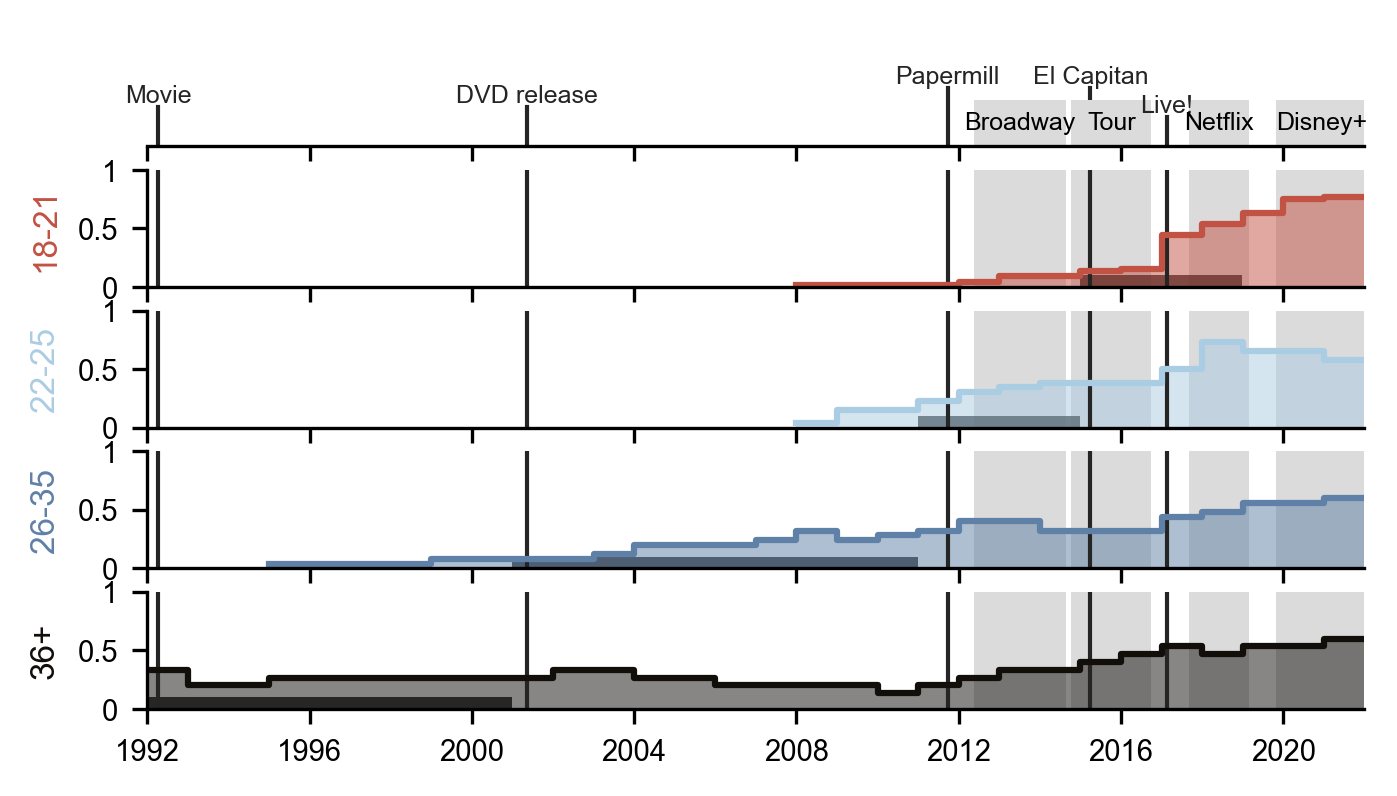

In [294]:

# Plots the reference
fig5, gs5 = _create_tl_figure(5, dpi=300)
ax5_tl = fig5.add_subplot(gs5[0, 1:], facecolor='None')
_build_ref_ax(ax5_tl)
ax5_tl.xaxis.set_tick_params(labelbottom=False)

# Gets the age groups
for i, ((age, [early, late, counts, perc, cperc]), color) in \
        enumerate(zip(*(birth_range.iterrows(), colors2))):
    print(age)
    
    # Makes the axis
    ax = fig5.add_subplot(gs5[i+1, 1:], facecolor='None', sharex=ax5_tl)
    ax.set_ylim(0, 5)
    _plot_ref_dur(ax, 0, 5.1)
    ax.xaxis.set_tick_params(labelbottom=(i == len(birth_range) - 1))
    ax.yaxis.set_tick_params(left=True, labelleft=True)
    
    # Plots the birth
    early_15 = early + pd.Timedelta('365.25D') * 15
    late_15 = late + pd.Timedelta('365.25D') * 15
    _plot_cohort_strip(ax, early_15, late_15, 0, 0.5,
                       color='k', label='', 
                       # font_color={3: 'white'}.get(i, 'k')
                       )
    # Plots the fandom activity
    _plot_activity(ax, by_age_year_perc.loc[age] * 5, colors=color)
    ax.set_yticks(np.arange(0, 5.1, 2.5))
    ax.set_yticklabels([0, 0.5, 1])
    ax.set_ylabel(age.replace(" - 60", '+').replace(" ", ''), color=color, size=8)
    
    sn.despine(ax=ax, left=False, right=True, top=True, bottom=False)

# First exposure and first media

I want to look at when people are active, and what media they saw.

In [297]:
print(describe_column('first_media', data_dict, data, show_notes=False))

Item 2: first_media (multiple choice)

1. What was your first exposure to Newsies?


     ----------------------------------------------------------------------
       Response                                                 Count
     ----------------------------------------------------------------------
       The 1992 movie                                             63 
       The 1992 movie soundtrack                                   3 
       The musical (Broadway or Tour)                             12 
       The original Broadway cast soundtrack                      15 
       The Newsies Live movie                                     33 
       Fandom                                                      2 
       Historical Strike                                           1 
       Promotional Videos                                          2 
     ----------------------------------------------------------------------



For this, we'll map the 1992 movie and movei sountrack together, and then combine fandom, promotional video, and historical strike into a single group.

In [298]:
data.replace(
    to_replace={
        'first_media': {'The 1992 movie soundtrack': 'The 1992 movie',
                        'Fandom': 'Other',
                        'Historical Strike': 'Other',
                        'Promotional Videos': 'Other',
                        }
    }, 
    inplace=True)
media_order = ['The 1992 movie', 'The musical (Broadway or Tour)', 
               'The original Broadway cast soundtrack', 'The Newsies Live movie',
               'Other']

data['first_media'].value_counts()[media_order]

The 1992 movie                           66
The musical (Broadway or Tour)           12
The original Broadway cast soundtrack    15
The Newsies Live movie                   33
Other                                     5
Name: first_media, dtype: int64

In [299]:
print(describe_column('first_period', data_dict, data, show_notes=False))

Item 3: first_period (multiple choice)

2. When (approximately) did you first become interested in or see Newsies?


     ----------------------------------------------------------------------
       Response                                                 Count
     ----------------------------------------------------------------------
       1992 - 1995                                                15 
       1996 - 1999                                                 6 
       2000 - 2003                                                 3 
       2004 - 2007                                                 5 
       2008 - 2010                                                 8 
       2011 - 2014                                                22 
       2015 - 2016                                                11 
       2017 - 2019                                                44 
       2020 -                                                     17 
     --------------------------

I think for display, I'm just going to tabulate the information, but I also want ot look at the intersection.

In [300]:
inter_counts = data.groupby(['first_media', 'first_period'], sort=False)['consent'].count()
inter_counts = inter_counts.unstack().fillna(0).loc[media_order]
inter_counts.sort_index(inplace=True, axis='columns')

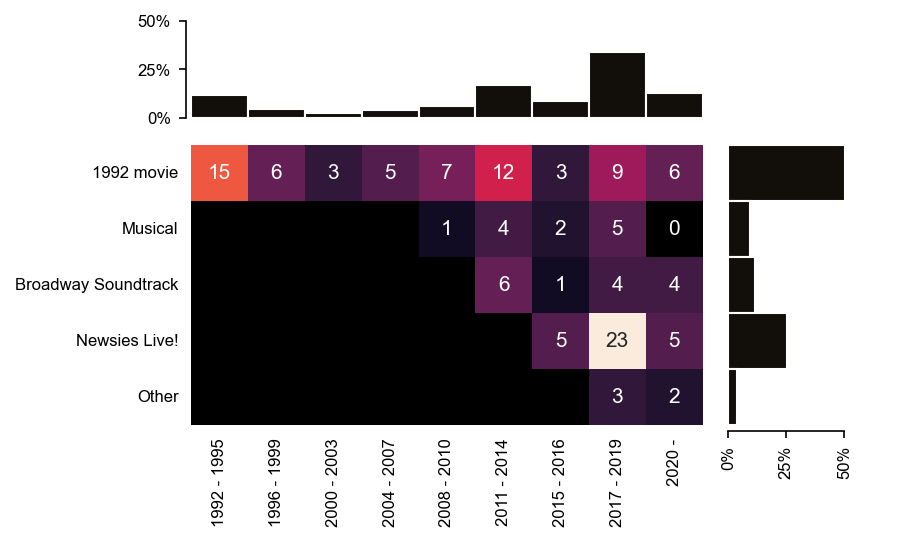

In [301]:
fig_1st = plt.figure(dpi=150, constrained_layout=True, facecolor='None', figsize=(6, 3.5))
gs_1st = fig_1st.add_gridspec(4, 4)
ax_1st = fig_1st.add_subplot(gs_1st[1:, :-1], facecolor='None')
ax_1st_years = fig_1st.add_subplot(gs_1st[0, :-1], sharex=ax_1st)
ax_1st_media = fig_1st.add_subplot(gs_1st[1:, -1], sharey=ax_1st)


# Plots the counts, and timing
ax_1st.fill_between([0, len(inter_counts.columns)], y1=0, 
                    y2=len(inter_counts.index), 
                    color='k', edgecolor='None') 
sn.heatmap(inter_counts.mask(inter_counts == 0), 
           ax=ax_1st, 
           cbar=False, 
           vmin=0,
           annot=inter_counts,
           )
ax_1st.text(ax_1st.get_xticks()[-1], 
            y=ax_1st.get_yticks()[1],
            s=0,
            ha='center', va='center', 
            color='w',
            zorder=5,
            )

ax_1st.set_yticklabels(['1992 movie', 'Musical', 'Broadway Soundtrack',
                        'Newsies Live!', 'Other'])
for ax_ in [ax_1st.xaxis, ax_1st.yaxis]:
    ax_.set_tick_params(left=False, labelleft=True, labelsize=8, length=0)
    ax_.get_label().set_visible(False)

ax_1st_media.barh(
    y=ax_1st_media.get_yticks(),
    width=data['first_media'].value_counts()[media_order] / len(data),
    height=1,
    edgecolor='w',
    color=colors[-1],
)
ax_1st_years.bar(
    x=ax_1st_years.get_xticks(),
    height=data['first_period'].value_counts().sort_index() / len(data),
    width=1,
    color=colors[-1],
    edgecolor='w',
)

for ax_ in [ax_1st_years.xaxis, ax_1st_media.yaxis]:
    ax_.set_tick_params(left=False, labelleft=False)
    ax_.get_label().set_visible(False)

ax_1st_years.set_ylim(0, 0.5)
ax_1st_media.set_xlim(0, 0.75)
ax_1st_media.set_xticks(np.arange(0, 0.75, 0.25))
ax_1st_years.set_yticks(np.arange(0, 0.51, 0.25))

ax_1st_years.set_xlim(np.array(ax_1st_years.get_xlim()) + np.array([-0.1, 0.1]))
ax_1st_media.set_ylim(np.array(ax_1st_media.get_ylim()) + np.array([0.1, -0.1]))
ax_1st_media.xaxis.set_tick_params(rotation=90)

for ax_ in [ax_1st_years.yaxis, ax_1st_media.xaxis]:
    ax_.set_tick_params(labelsize=8)
    ax_.set_major_formatter(StrMethodFormatter('{x:1.0%}'))

sn.despine(ax=ax_1st_media, top=True, right=True, trim=True, bottom=False, left=True)
sn.despine(ax=ax_1st_years, top=True, right=True, trim=True, bottom=True, left=False)

## Age and First Media

But I also want ot look at this by cohort/generation. I'm going to use this collapsed age, and the first media. We'll re-group the first media here, as well.

In [308]:
age_media = data.groupby(['first_media', 'age3'], sort=True).count()['consent']
age_media.rename({"The original Broadway cast soundtrack": "The musical (Broadway or Tour)"}, inplace=True)
age_media = age_media.groupby(['first_media', 'age3']).sum()
age_media = age_media.unstack().fillna(0).astype(int)
# age_media = age_media.loc[media_order]
age_media.drop(index=['Other'], inplace=True)
age_media = age_media.loc[['The 1992 movie', 'The musical (Broadway or Tour)',
                           'The Newsies Live movie']]
age_media

age3,18 - 21,22 - 25,26 - 35,36 - 60
first_media,,,,
The 1992 movie,21,10,20,15
The musical (Broadway or Tour),16,10,1,0
The Newsies Live movie,23,6,4,0


In [309]:
(age_media.sum(axis=1) / age_media.sum().sum()).round(3)

first_media
The 1992 movie                    0.524
The musical (Broadway or Tour)    0.214
The Newsies Live movie            0.262
dtype: float64

And then, we'll do a chi-squared test looking at the first media and age.

In [310]:
afm_chi2, afm_p, afm_dof, afm_exp = scipy.stats.chi2_contingency(age_media)
afm_exp = pd.DataFrame(afm_exp, index=age_media.index, columns=age_media.columns)
afm_exp.round(0)

age3,18 - 21,22 - 25,26 - 35,36 - 60
first_media,,,,
The 1992 movie,31.0,14.0,13.0,8.0
The musical (Broadway or Tour),13.0,6.0,5.0,3.0
The Newsies Live movie,16.0,7.0,7.0,4.0


In [311]:
print(
    f'Using a chi-square test with {afm_dof:d} dof, we can reject the null'
    f'hypothesis that\nthere is no relationship between age and first media exposure '
    f'(p={afm_p:1.1g}, chi2={afm_chi2:1.1f})'
)

Using a chi-square test with 6 dof, we can reject the nullhypothesis that
there is no relationship between age and first media exposure (p=7e-06, chi2=34.0)


And then, let's visualize thsi because meh, its worth visualizing things!

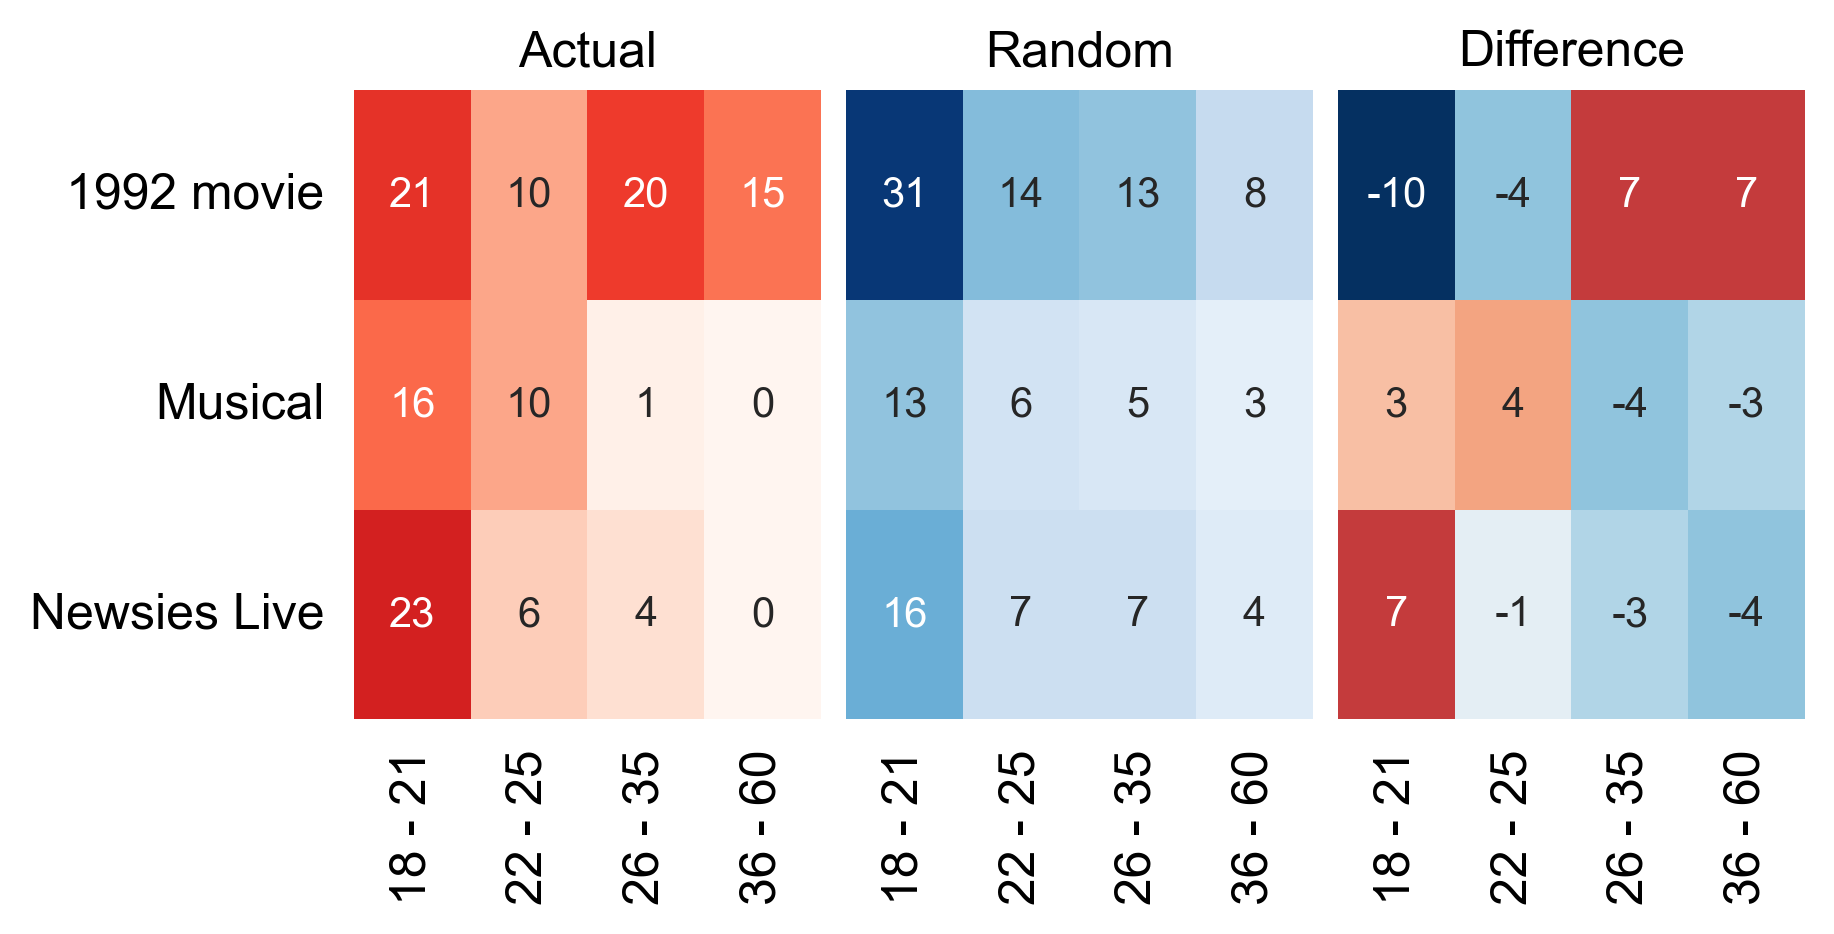

In [313]:
fig, axes = plt.subplots(1, 3, 
                         sharex=True, sharey=True,
                         dpi=300, 
                         constrained_layout=True, 
                         figsize=(6, 3), 
                         )

[ax_act, ax_exp, ax_dif] = axes
sn.heatmap(age_media, annot=age_media,
           ax=ax_act, 
           cbar=False, 
           vmin=0, vmax=32, 
           cmap='Reds')
sn.heatmap(afm_exp.round(0),  annot=afm_exp.round(0),
           ax=ax_exp, 
           cbar=False, 
           vmin=0, vmax=32, 
           cmap='Blues')
sn.heatmap(np.round(age_media - afm_exp, 0), 
           annot=np.round(age_media - afm_exp, 0),
           ax=ax_dif, 
           cbar=False, 
           vmin=-10, vmax=10,  
           cmap='RdBu_r')

for ax, title in zip(*(axes, ['Actual', 'Random', 'Difference'])):
    ax.xaxis.set_tick_params(labelsize=12, bottom=False, rotation=90)
    ax.yaxis.set_tick_params(labelsize=12, left=False)
    ax.set_yticklabels(['1992 movie', 'Musical', 'Newsies Live'])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.set_title(title)

Okay, so younger fans are significantly less likely to have see the movie, and are more likely to have seen Newsies Live. Where as older fans are more likely to have seen the musical or soundtrack.

## First media, Preference, and age
I'd also like to look at exposure and preference.

In [314]:
data['media_preference'].value_counts()

The stage production               50
The film                           47
I enjoy them both equally          26
I have only seen the stage show     5
I have only seen the film           3
Name: media_preference, dtype: int64

Let's start by looking at the intersection between preference and first media. For this purpose, we're going to group Live with Boradway, since they're similar stories and overlaps.

In [315]:
data['first_media2'] = data['first_media'].replace({
    'The 1992 movie': 'The film',
    'The musical (Broadway or Tour)': 'The stage production',
    "The original Broadway cast soundtrack": 'The stage production',
    'The Newsies Live movie': 'Newsies Live',
})

In [316]:
data['first_media2'].value_counts()

The film                66
Newsies Live            33
The stage production    27
Other                    5
Name: first_media2, dtype: int64

Let's first check if there's an ineraction between preference and first media. Then, I want to know if there's an age-related effect. For this, we're probably jsut going to generate tables, and we'll droup out people who whose introductions weren't the movie, the musical, or newsies live and who haven't seen both.

In [317]:
pref_sub = data[['media_preference', 'first_media2', 'age3']].copy()
keep_media = ['The film', 'The stage production', 'Newsies Live', 
              'I enjoy them both equally']
pref_sub = \
    pref_sub.loc[pref_sub[['media_preference', 'first_media2']].isin(keep_media).all(axis=1)].copy()

In [318]:
pre_first = pref_sub.groupby(['media_preference', 'first_media2']).count()['age3']
pre_first = pre_first.unstack()
pre_first = pre_first.loc[['The film', 'The stage production', 'I enjoy them both equally'],
                          ['The film',  'The stage production', 'Newsies Live'],
                          ]
pre_first

first_media2,The film,The stage production,Newsies Live
media_preference,,,
The film,39,6,1
The stage production,12,15,22
I enjoy them both equally,13,4,6


In [319]:
pre_fist_chi2_res = scipy.stats.chi2_contingency(pre_first)
pre_exp = pd.DataFrame(pre_fist_chi2_res[-1], index=pre_first.index, columns=pre_first.columns)
pre_exp.round(0)

first_media2,The film,The stage production,Newsies Live
media_preference,,,
The film,25.0,10.0,11.0
The stage production,27.0,10.0,12.0
I enjoy them both equally,12.0,5.0,6.0


In [320]:
print('chi2 = {0:>3.1f} ({2:d} dof), p = {1:1.1g}'.format(*pre_fist_chi2_res))

chi2 = 37.2 (4 dof), p = 2e-07


Let's drop the people who are unwilling to comit

In [321]:
pre_first_decider = pre_first.copy().drop(index=['I enjoy them both equally'])
print(pre_first_decider)

first_media2          The film  The stage production  Newsies Live
media_preference                                                  
The film                    39                     6             1
The stage production        12                    15            22


In [322]:
decider_first_chi2 = scipy.stats.chi2_contingency(pre_first_decider)
decider_exp = pd.DataFrame(data=decider_first_chi2[-1], 
                           index=pre_first_decider.index,
                           columns=pre_first_decider.columns
                           )
print('chi2 = {0:>3.1f} ({2:d} dof), p = {1:1.1g}\n'.format(*decider_first_chi2))
print(decider_exp.round(0).astype(int))

chi2 = 37.3 (2 dof), p = 8e-09

first_media2          The film  The stage production  Newsies Live
media_preference                                                  
The film                    25                    10            11
The stage production        26                    11            12


Okay, so that's statistically significant. We can also look at age.

In [323]:
pref_age = pref_sub.groupby(['media_preference', 'age3']).count()['first_media2']
pref_age = pref_age.unstack().fillna(0)
pref_age = pref_age.loc[['The film', 'The stage production', 'I enjoy them both equally']]
pref_age

age3,18 - 21,22 - 25,26 - 35,36 - 60
media_preference,,,,
The film,19,8,10,9
The stage production,28,14,6,1
I enjoy them both equally,8,4,7,4


I'm going to start by testing if there's an age-related distribution based on the 
media prefered.

In [324]:
chi2_age_by_media = pd.DataFrame(
    data=scipy.stats.chisquare(pref_age, axis=1),
    columns=pref_age.index,
    index=['chi-2', 'p-value']
).T
chi2_age_by_media.apply(lambda x: 'p={1:1.2g} (chi2={0:1.1f})'.format(*x.values), axis=1)

media_preference
The film                      p=0.082 (chi2=6.7)
The stage production         p=2e-07 (chi2=34.0)
I enjoy them both equally      p=0.53 (chi2=2.2)
dtype: object

I'm going to drop the last group, and then check for a counfounding effect.

In [325]:
pref_age.drop(index=['I enjoy them both equally'], inplace=True)
print(pref_age)
exp_age_chi2 = scipy.stats.chi2_contingency(pref_age)
pref_age_exp = pd.DataFrame(data=exp_age_chi2[-1], 
                           index=pref_age.index,
                           columns=pref_age.columns
                           )
print('chi2 = {0:>3.1f} ({2:d} dof), p = {1:1.1g}\n'.format(*exp_age_chi2))
print(pref_age_exp.round(0).astype(int))

age3                  18 - 21  22 - 25  26 - 35  36 - 60
media_preference                                        
The film                   19        8       10        9
The stage production       28       14        6        1
chi2 = 10.7 (3 dof), p = 0.01

age3                  18 - 21  22 - 25  26 - 35  36 - 60
media_preference                                        
The film                   23       11        8        5
The stage production       24       11        8        5


I want to do a logistic regression since these are confounded. So, yeah, let's try that. 

In [330]:
pref_sub['film'] = (pref_sub['media_preference'] == 'The film') * 1


In [338]:
fit_ = smf.logit('film ~ first_media2 + age3', 
                data=pref_sub.loc[pref_sub['media_preference'] != 'I enjoy them both equally']
               ).fit()
print(fit_.summary())

Optimization terminated successfully.
         Current function value: 0.458240
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   film   No. Observations:                   95
Model:                          Logit   Df Residuals:                       89
Method:                           MLE   Df Model:                            5
Date:                Wed, 13 Apr 2022   Pseudo R-squ.:                  0.3384
Time:                        22:02:55   Log-Likelihood:                -43.533
converged:                       True   LL-Null:                       -65.802
Covariance Type:            nonrobust   LLR p-value:                 1.801e-08
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.9993      1.0

In [342]:
np.exp(pd.concat(axis=1, objs=[fit_.params, fit_.conf_int()])).round(1)

,0,0,1
Intercept,0.0,0.0,0.4
first_media2[T.The film],62.7,7.3,541.8
first_media2[T.The stage production],9.5,1.0,88.1
age3[T.22 - 25],0.6,0.2,2.3
age3[T.26 - 35],0.9,0.2,3.9
age3[T.36 - 60],2.9,0.3,27.9


In [343]:
fit_.pvalues

Intercept                               0.003664
first_media2[T.The film]                0.000169
first_media2[T.The stage production]    0.048127
age3[T.22 - 25]                         0.493971
age3[T.26 - 35]                         0.897686
age3[T.36 - 60]                         0.361004
dtype: float64